In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import tensorflow
import keras

In [7]:
# load the dataset 
data = pd.read_csv("Churn_Modelling.csv")
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
# drop the unwanted columns 
data.drop(['RowNumber','CustomerId','Surname'],axis=1,inplace=True)

In [9]:
#encode categorical variables 
lb_enc = LabelEncoder()
data['Gender'] = lb_enc.fit_transform(data['Gender'])


In [10]:
ohe_enc = OneHotEncoder(handle_unknown='ignore')
geo_data = ohe_enc.fit_transform(data[['Geography']]).toarray()


In [12]:
geo_df = pd.DataFrame(geo_data,columns=ohe_enc.get_feature_names_out())
new_df = pd.concat([data.drop('Geography',axis=1),geo_df],axis=1)

In [14]:
# split data 
X = new_df.drop('EstimatedSalary',axis=1)
y = new_df['EstimatedSalary']

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# split the data in training and testing sets 
X_train,X_test ,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# scale the features 
scaler = StandardScaler()
X_scale_train = np.array(scaler.fit_transform(X_train))
X_scale_test = np.array(scaler.transform(X_test))


In [16]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.callbacks import EarlyStopping
import datetime
from livelossplot import PlotLossesKerasTF

In [38]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1,activation='linear')
])
model.summary()

/Users/milandangi/Desktop/Churn-Detection-System/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,945 (11.50 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss='mean_absolute_error',metrics=['mae'])


In [40]:
early_stop_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


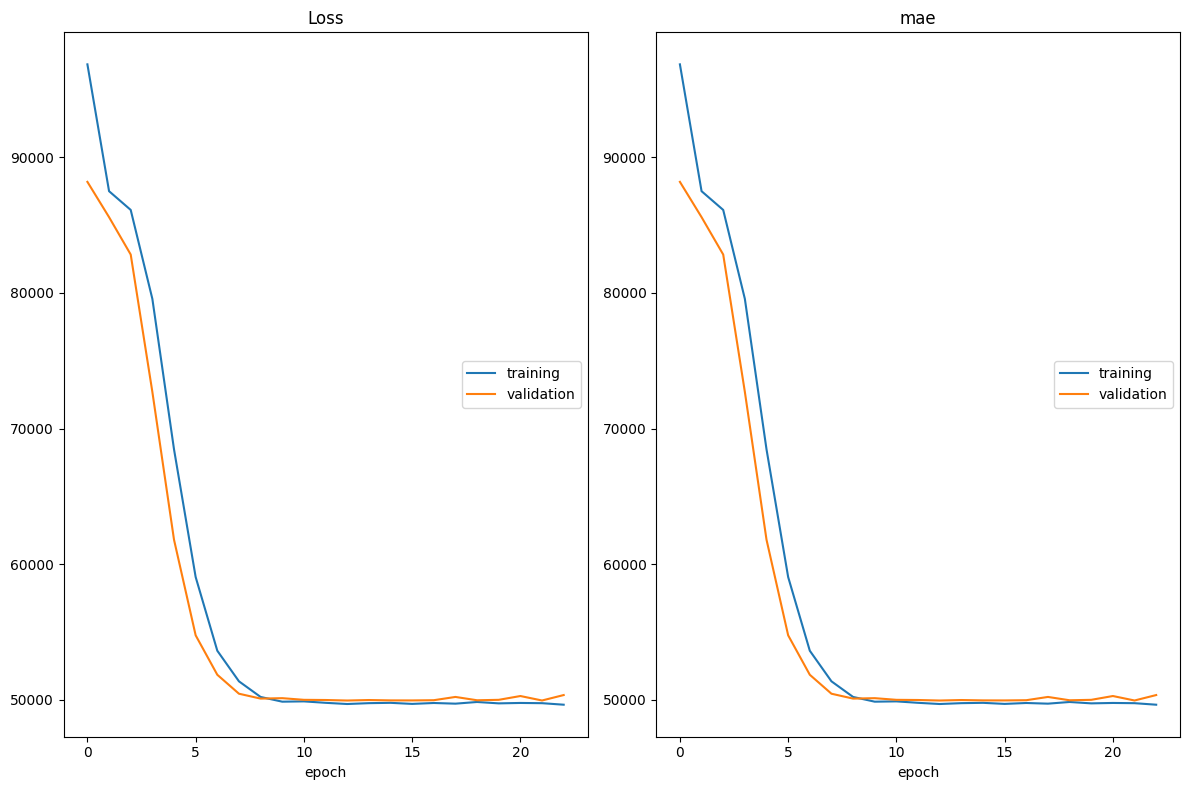

Loss
	training         	 (min: 49634.934, max: 96850.242, cur: 49634.934)
	validation       	 (min: 49943.180, max: 88185.797, cur: 50346.426)
mae
	training         	 (min: 49634.934, max: 96850.242, cur: 49634.934)
	validation       	 (min: 49943.180, max: 88185.797, cur: 50346.426)
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 49634.9336 - mae: 49634.9336 - val_loss: 50346.4258 - val_mae: 50346.4258


In [41]:
model_history = model.fit(
    X_scale_train,
    y_train,
    validation_data= (X_scale_test,y_test),
    epochs = 100,
    callbacks = [PlotLossesKerasTF(), early_stop_callback],
    verbose = 1
)

In [42]:
# Evaluate the model on test data 
test_loss ,test_mae = model.evaluate(X_scale_test,y_test)
print(F"TEST MAE:{test_mae}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 49943.1797 - mae: 49943.1797
TEST MAE:49943.1796875


In [43]:
model.save('regression_model.h5')

In [45]:
# test on new data 
input_data = {
'CreditScore':700,
 'Geography':'Spain',
 'Gender':'Male',
 'Age': 34,
 'Tenure':3,
 'Balance': 36815.64,
 'NumOfProducts': 2,
 'HasCrCard': 1,
 'IsActiveMember':1,
 'Exited':0
}
test_data = pd.DataFrame(input_data,index=[0])
test_data['Gender'] = lb_enc.transform(test_data['Gender'])
x = ohe_enc.transform([test_data['Geography'],]).toarray()
test_geo_enc = pd.DataFrame(x,columns=ohe_enc.get_feature_names_out())
test_dat = pd.concat([test_data.drop('Geography',axis=1),test_geo_enc],axis=1)


/Users/milandangi/Desktop/Churn-Detection-System/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


In [47]:
test_data = scaler.transform(test_dat)

In [50]:
model.predict(test_dat)[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


47991630.0